In [458]:
from keras.models import Sequential
from keras.layers import Dense, Activation
from keras.optimizers import Adam, SGD
from keras.utils.np_utils import to_categorical  
from keras.datasets import cifar100
from keras.optimizers import Adam
from keras.layers import Dense, Activation, Dropout
import numpy as np

# (training_data, training_labels), (testing_data, testing_labels) = (cifar100.load_data("coarse"))

# centre the data
def centre_data(train, test, validation):
    
    # calculate the means for each attribute of the training data
    column_means = np.mean(train, axis=0) 
    
    # centre training data by subtracting training data attribute means
    for i in range(len(train)):
        train[i] = train[i] - column_means
    
    # centre testing data by subtracting training data attribute means
    for x in range(len(test)):
        test[x] = test[x] - column_means
        
    # centre testing data by subtracting training data attribute means
    for x in range(len(validation)):
        validation[x] = validation[x] - column_means
        
    return train, test, validation

# helper function for concatenating labels onto their corresponding data points
def concatenate_data(training_data, training_labels):
    return np.column_stack((training_data, training_labels))

# apply PCA on the data 
def PCA(variance_target, training_data, testing_data, validation_data):

    U, sigma, Vt = np.linalg.svd(training_data, full_matrices=False)
    
    sum_square_singular = np.sum(sigma**2)
    
    ratios = sigma**2/sum_square_singular
    
                
    n_components = 0
    explained_variance = 0
    
    # determine how many principle components must be retained to maintain the target level of explained variance
    for i in range(len(ratios)):
        if explained_variance >= variance_target:
            break
        else: 
            n_components += 1
            explained_variance += ratios[i]
    
    return training_data.dot(Vt.T[:, :n_components]), testing_data.dot(Vt.T[:, :n_components]), validation_data.dot(Vt.T[:, :n_components])


# data set is randomised and then split in a 70:30 ratio for training:validation sets
def split_into_validation_training(training_matrix):
    
    import random
    random.shuffle(training_matrix)

    training_set = training_matrix[:int(len(training_matrix)*0.7)]
    validation_set = training_matrix[int(len(training_matrix)*0.7):]
    
    return training_set, validation_set

def load_in_dataset_and_preprocess(explained_variance):
    (training_data, training_labels), (testing_data, testing_labels) = (cifar100.load_data("coarse"))
    
    # reshape the data 
    training_data = training_data.reshape(50000, 3072)
    testing_data = testing_data.reshape(10000, 3072)
    
    concatenated_training = concatenate_data(training_data, training_labels)
    
    training_set, validation_set = split_into_validation_training(concatenated_training)
    
    training_data = training_set[:, :-1]
    training_labels = np.squeeze(training_set[:, -1])
    
    validation_data = validation_set[:, :-1]
    validation_labels = np.squeeze(validation_set[:, -1])
    
    training_data = training_data.astype('float32')
    testing_data = testing_data.astype('float32')
    validation_data = validation_data.astype('float32')

#     # Centre data
    training_data, testing_data, validation_data = centre_data(training_data, testing_data, validation_data)

#     # Apply PCA
#    training_data, testing_data, validation_data = PCA(explained_variance, training_data, testing_data, validation_data)
    
    # Normalization of pixel values (to [0-1] range)
    training_data = training_data / 255
    testing_data = testing_data / 255
    validation_data = validation_data / 255
    
    return training_data, training_labels, testing_data, testing_labels, validation_data, validation_labels

# training_data, training_labels, testing_data, testing_labels, validation_data, validation_labels = load_in_dataset_and_preprocess(0.8)


In [459]:
# training_data, training_labels, testing_data, testing_labels, validation_data, validation_labels = load_in_dataset_and_preprocess(0.8)

In [460]:
from keras.optimizers import Adam
from keras.layers import Dense, Activation, Dropout

def run_MLP_model(training_data, training_labels, testing_data, testing_labels, first_activation_function, second_activation_function, num_hidden_units, learning_rate, optimiser, decay_level, momentum, epochs, loss_function):

    model = Sequential()

    model.add(Dense(num_hidden_units, activation=first_activation_function, input_dim=training_data.shape[1]))
    model.add(Dropout(0.5))
    model.add(Dense(num_hidden_units, activation=first_activation_function))
    model.add(Dropout(0.5))
    model.add(Dense(20, activation=second_activation_function))

    if (optimiser == 'SGD'):
        op = SGD(lr=learning_rate, decay=decay_level, momentum=momentum, nesterov=True)

    else:
        op = Adam(lr=learning_rate, decay=decay_level)

    # can also use loss function categorical_crossentropy
    # or optimiser SGD
    # try with different optimisers and loss functions
    model.compile(optimizer=op,
                  loss=loss_function,
                  metrics=['accuracy'])

    history = model.fit(training_data, training_labels, epochs=epochs, batch_size=32, verbose=0, validation_split=0.2)

    score = model.evaluate(testing_data, testing_labels, batch_size=128, verbose=0)
    
    return score[1]

In [461]:
# score = run_MLP_model(training_data, training_labels, validation_data, validation_labels, 'relu', 'softmax', 256, 0.001, 'Adam', 1e-6, 0.9, 20, 'sparse_categorical_crossentropy')
# print(score[1])

In [462]:
### Converting images to grayscale

In [463]:
def convert_to_grayscale(train, test):
    rgb_weights = [0.2989, 0.5870, 0.1140]
    gray_train = np.dot(train[:][...,:3], rgb_weights)
    gray_test = np.dot(test[:][...,:3], rgb_weights)
    return gray_train.astype(int), gray_test.astype(int)

In [464]:
### Increasing image contrast

In [465]:
def increase_image_contrast(image, strength):
    p_low, p_high = np.percentile(image, (strength, 100 - strength))
    return (exposure.rescale_intensity(image, in_range=(p_low, p_high))).astype(int)

def increase_all_contrast(train, test, strength=10):
    new_train = np.copy(train)
    new_test = np.copy(test)
    for i in range(len(train)):
        new_train[i] = increase_image_contrast(train[i], strength)
    for i in range(len(test)):
        new_test[i] = increase_image_contrast(test[i], strength)
    return new_train, new_test

In [466]:
### Image equalisation

In [467]:
def equalize_hist(image):
    return (exposure.equalize_hist(image) * 255).astype(int)

def equalize_hist_all(train, test):
    new_train = np.copy(train)
    new_test = np.copy(test)
    for i in range(len(train)):
        new_train[i] = equalize_hist(train[i])
    for i in range(len(test)):
        new_test[i] = equalize_hist(test[i])
    return new_train, new_test



In [468]:
def equalize_adapthist(image, clip_lim):
    return (exposure.equalize_adapthist(image, clip_limit=clip_lim) * 255).astype(int)

def equalize_adapthist_all(train, test, clip_limit=0.03):
    new_train = np.copy(train)
    new_test = np.copy(test)
    for i in range(len(train)):
        new_train[i] = equalize_adapthist(train[i], clip_limit)
    for i in range(len(test)):
        new_test[i] = equalize_adapthist(test[i], clip_limit)
    return new_train, new_test

In [469]:
### Edge detection

In [470]:
def canny_edge_filter_all(train, test, sig=1):
    if (len(train.shape) > 3):
        train, test = convert_to_grayscale(train, test)
    new_train = np.copy(train)
    new_test = np.copy(test)
    for i in range(len(train)):
        new_train[i] = feature.canny(train[i].astype(float), sigma=sig)
    for i in range(len(test)):
        new_test[i] = feature.canny(test[i].astype(float), sigma=sig)
    return new_train, new_test

In [471]:
### flattening the images

In [472]:
def flatten_data(x_train, y_train, x_test, y_test):
    new_image_shape = 1
    for dim in range(1, len(x_train.shape)):
        new_image_shape *= x_train.shape[dim]
        
    flat_x_train = x_train.reshape((x_train.shape[0], new_image_shape))
    flat_y_train = np.ravel(y_train)
    
    flat_x_test = x_test.reshape((x_test.shape[0], new_image_shape))
    flat_y_test = np.ravel(y_test)
    return flat_x_train, flat_y_train, flat_x_test, flat_y_test

In [473]:
### Testing

In [474]:
import time
import csv

In [475]:
def nano_to_seconds(nanoseconds):
    """Converts nanoseconds to seconds rounded to the nearest 5 decimal places.
    
    Parameters
    ----------
    nanoseconds : int
        The nanoseconds to convert
    """

    return np.round((nanoseconds / 1e+9), 5)

In [476]:
## test preprocessing

In [477]:
## test second activation functions

In [478]:

def test_MLP_second_activation_functions():
    activation_functions = ['tanh', 'softmax']
    training_data, training_labels, testing_data, testing_labels, validation_data, validation_labels = load_in_dataset_and_preprocess(0.8)
    with open('mlp_second_activation_function.csv', mode='w', newline='') as csv_file:
        result_writer = csv.writer(csv_file, delimiter=',', quotechar='"', quoting=csv.QUOTE_MINIMAL)
        result_writer.writerow(['1st Activation Function', '2nd Activation Function', 'Loss Function', 'Learning Rate', 'Optimiser', 'Momentum', 'Decay', 'Epochs', 'Number Hidden Units', 'Average Accuracy', 'Average Runtime'])
        momentum = 0.9
        decay=1e-6
        learning_rate = 0.001
        first_activation_function = 'relu'
        second_activation_function = 'softmax'
        loss = 'sparse_categorical_crossentropy'
        optimiser = 'Adam'
        epochs = 20
        num_hidden_units = 256
        for activation_function in activation_functions:
            num_tests = 0
            total_accuracy = 0
            total_runtime = 0
            for i in range(2):
                start_time = time.time_ns()
                total_accuracy += run_MLP_model(training_data, training_labels, validation_data, validation_labels, first_activation_function, activation_function, num_hidden_units, learning_rate, optimiser, decay, momentum, epochs, loss)
                end_time = time.time_ns()
                total_runtime += nano_to_seconds(end_time - start_time)
                num_tests += 1
            avg_accuracy = np.round(total_accuracy / float(num_tests), 5)
            avg_runtime = np.round(total_runtime / float(num_tests), 5)
            result_writer.writerow([first_activation_function, activation_function, loss, learning_rate, optimiser, momentum, decay, epochs, num_hidden_units, avg_accuracy, avg_runtime])

# test_MLP_second_activation_functions()

In [479]:
## test first activation functions

In [480]:
def test_MLP_first_activation_functions():
    activation_functions = ['elu', 'relu', 'tanh']
    training_data, training_labels, testing_data, testing_labels, validation_data, validation_labels = load_in_dataset_and_preprocess(0.8)
    with open('mlp_first_activation_function.csv', mode='w', newline='') as csv_file:
        result_writer = csv.writer(csv_file, delimiter=',', quotechar='"', quoting=csv.QUOTE_MINIMAL)
        result_writer.writerow(['1st Activation Function', '2nd Activation Function', 'Loss Function', 'Learning Rate', 'Optimiser', 'Momentum', 'Decay', 'Epochs', 'Number Hidden Units', 'Average Accuracy', 'Average Runtime'])
        momentum = 0.9
        decay=1e-6
        learning_rate = 0.001
        first_activation_function = 'relu'
        second_activation_function = 'softmax'
        loss = 'sparse_categorical_crossentropy'
        optimiser = 'Adam'
        epochs = 20
        num_hidden_units = 256
        for activation_function in activation_functions:
            num_tests = 0
            total_accuracy = 0
            total_runtime = 0
            for i in range(2):
                start_time = time.time_ns()
                total_accuracy += run_MLP_model(training_data, training_labels, validation_data, validation_labels, activation_function, second_activation_function, num_hidden_units, learning_rate, optimiser, decay, momentum, epochs, loss)
                end_time = time.time_ns()
                total_runtime += nano_to_seconds(end_time - start_time)
                num_tests += 1
            avg_accuracy = np.round(total_accuracy / float(num_tests), 5)
            avg_runtime = np.round(total_runtime / float(num_tests), 5)
            result_writer.writerow([activation_function, second_activation_function, loss, learning_rate, optimiser, momentum, decay, epochs, num_hidden_units, avg_accuracy, avg_runtime])

# test_MLP_first_activation_functions()

In [481]:
## test learning rates

In [482]:
def test_MLP_learning_rates():
    learning_rates = [0.01, 0.05, 0.001]
    training_data, training_labels, testing_data, testing_labels, validation_data, validation_labels = load_in_dataset_and_preprocess(0.8)
    with open('mlp_learning_rates.csv', mode='w', newline='') as csv_file:
        result_writer = csv.writer(csv_file, delimiter=',', quotechar='"', quoting=csv.QUOTE_MINIMAL)
        result_writer.writerow(['1st Activation Function', '2nd Activation Function', 'Loss Function', 'Learning Rate', 'Optimiser', 'Momentum', 'Decay', 'Epochs', 'Number Hidden Units', 'Average Accuracy', 'Average Runtime'])
        momentum = 0.9
        decay=1e-6
        learning_rate = 0.001
        first_activation_function = 'relu'
        second_activation_function = 'softmax'
        loss = 'sparse_categorical_crossentropy'
        optimiser = 'Adam'
        epochs = 20
        num_hidden_units = 256
        for lr in learning_rates:
            num_tests = 0
            total_accuracy = 0
            total_runtime = 0
            for i in range(2):
                start_time = time.time_ns()
                total_accuracy += run_MLP_model(training_data, training_labels, validation_data, validation_labels, first_activation_function, second_activation_function, num_hidden_units, lr, optimiser, decay, momentum, epochs, loss)
                end_time = time.time_ns()
                total_runtime += nano_to_seconds(end_time - start_time)
                num_tests += 1
            avg_accuracy = np.round(total_accuracy / float(num_tests), 5)
            avg_runtime = np.round(total_runtime / float(num_tests), 5)
            result_writer.writerow([first_activation_function, second_activation_function, loss, lr, optimiser, momentum, decay, epochs, num_hidden_units, avg_accuracy, avg_runtime])

# test_MLP_learning_rates()

In [483]:
## test number of hidden units

def test_MLP_hidden_units():
    hidden_units_numbers = [50, 256, 500]
    training_data, training_labels, testing_data, testing_labels, validation_data, validation_labels = load_in_dataset_and_preprocess(0.8)
    with open('mlp_hidden_units.csv', mode='w', newline='') as csv_file:
        result_writer = csv.writer(csv_file, delimiter=',', quotechar='"', quoting=csv.QUOTE_MINIMAL)
        result_writer.writerow(['1st Activation Function', '2nd Activation Function', 'Loss Function', 'Learning Rate', 'Optimiser', 'Momentum', 'Decay', 'Epochs', 'Number Hidden Units', 'Average Accuracy', 'Average Runtime'])
        momentum = 0.9
        decay=1e-6
        learning_rate = 0.001
        first_activation_function = 'relu'
        second_activation_function = 'softmax'
        loss = 'sparse_categorical_crossentropy'
        optimiser = 'Adam'
        epochs = 20
        num_hidden_units = 256
        for hu in hidden_units_numbers:
            num_tests = 0
            total_accuracy = 0
            total_runtime = 0
            for i in range(2):
                start_time = time.time_ns()
                total_accuracy += run_MLP_model(training_data, training_labels, validation_data, validation_labels, first_activation_function, second_activation_function, hu, learning_rate, optimiser, decay, momentum, epochs, loss)
                end_time = time.time_ns()
                total_runtime += nano_to_seconds(end_time - start_time)
                num_tests += 1
            avg_accuracy = np.round(total_accuracy / float(num_tests), 5)
            avg_runtime = np.round(total_runtime / float(num_tests), 5)
            result_writer.writerow([first_activation_function, second_activation_function, loss, learning_rate, optimiser, momentum, decay, epochs, hu, avg_accuracy, avg_runtime])

# test_MLP_hidden_units()

In [484]:
## test decay

def test_MLP_decay_rates():
    decay_rates = [0.00001, 0.000001, 0.0000001]
    training_data, training_labels, testing_data, testing_labels, validation_data, validation_labels = load_in_dataset_and_preprocess(0.8)
    with open('mlp_decay_rates.csv', mode='w', newline='') as csv_file:
        result_writer = csv.writer(csv_file, delimiter=',', quotechar='"', quoting=csv.QUOTE_MINIMAL)
        result_writer.writerow(['1st Activation Function', '2nd Activation Function', 'Loss Function', 'Learning Rate', 'Optimiser', 'Momentum', 'Decay', 'Epochs', 'Number Hidden Units', 'Average Accuracy', 'Average Runtime'])
        momentum = 0.9
        decay=1e-6
        learning_rate = 0.001
        first_activation_function = 'relu'
        second_activation_function = 'softmax'
        loss = 'sparse_categorical_crossentropy'
        optimiser = 'Adam'
        epochs = 20
        num_hidden_units = 256
        for dr in decay_rates:
            num_tests = 0
            total_accuracy = 0
            total_runtime = 0
            for i in range(2):
                start_time = time.time_ns()
                total_accuracy += run_MLP_model(training_data, training_labels, validation_data, validation_labels, first_activation_function, second_activation_function, num_hidden_units, learning_rate, optimiser, dr, momentum, epochs, loss)
                end_time = time.time_ns()
                total_runtime += nano_to_seconds(end_time - start_time)
                num_tests += 1
            avg_accuracy = np.round(total_accuracy / float(num_tests), 5)
            avg_runtime = np.round(total_runtime / float(num_tests), 5)
            result_writer.writerow([first_activation_function, second_activation_function, loss, learning_rate, optimiser, momentum, dr, epochs, num_hidden_units, avg_accuracy, avg_runtime])

# test_MLP_decay_rates()

In [485]:
## test momentum 
def test_MLP_momentums():
    momentums = [0.5, 0.7, 0.9]
    training_data, training_labels, testing_data, testing_labels, validation_data, validation_labels = load_in_dataset_and_preprocess(0.8)
    with open('mlp_momentums.csv', mode='w', newline='') as csv_file:
        result_writer = csv.writer(csv_file, delimiter=',', quotechar='"', quoting=csv.QUOTE_MINIMAL)
        result_writer.writerow(['1st Activation Function', '2nd Activation Function', 'Loss Function', 'Learning Rate', 'Optimiser', 'Momentum', 'Decay', 'Epochs', 'Number Hidden Units', 'Average Accuracy', 'Average Runtime'])
#         momentum = 0.9
        decay=1e-6
        learning_rate = 0.001
        first_activation_function = 'relu'
        second_activation_function = 'softmax'
        loss = 'sparse_categorical_crossentropy'
        optimiser = 'SGD'
        epochs = 20
        num_hidden_units = 256
        for momentum in momentums:
            num_tests = 0
            total_accuracy = 0
            total_runtime = 0
            for i in range(2):
                start_time = time.time_ns()
                total_accuracy += run_MLP_model(training_data, training_labels, validation_data, validation_labels, first_activation_function, second_activation_function, num_hidden_units, learning_rate, optimiser, decay, momentum, epochs, loss)
                end_time = time.time_ns()
                total_runtime += nano_to_seconds(end_time - start_time)
                num_tests += 1
            avg_accuracy = np.round(total_accuracy / float(num_tests), 5)
            avg_runtime = np.round(total_runtime / float(num_tests), 5)
            result_writer.writerow([first_activation_function, second_activation_function, loss, learning_rate, optimiser, momentum, decay, epochs, num_hidden_units, avg_accuracy, avg_runtime])

# test_MLP_momentums()

In [486]:
## test epochs

def test_MLP_epochs():
    diff_epochs = [20, 50, 100]
    training_data, training_labels, testing_data, testing_labels, validation_data, validation_labels = load_in_dataset_and_preprocess(0.8)
    with open('mlp_epochs.csv', mode='w', newline='') as csv_file:
        result_writer = csv.writer(csv_file, delimiter=',', quotechar='"', quoting=csv.QUOTE_MINIMAL)
        result_writer.writerow(['1st Activation Function', '2nd Activation Function', 'Loss Function', 'Learning Rate', 'Optimiser', 'Momentum', 'Decay', 'Epochs', 'Number Hidden Units', 'Average Accuracy', 'Average Runtime'])
        momentum = 0.9
        decay=1e-6
        learning_rate = 0.001
        first_activation_function = 'relu'
        second_activation_function = 'softmax'
        loss = 'sparse_categorical_crossentropy'
        optimiser = 'Adam'
#         epochs = 20
        num_hidden_units = 256
        for epochs in diff_epochs:
            num_tests = 0
            total_accuracy = 0
            total_runtime = 0
            for i in range(2):
                start_time = time.time_ns()
                total_accuracy += run_MLP_model(training_data, training_labels, validation_data, validation_labels, first_activation_function, second_activation_function, num_hidden_units, learning_rate, optimiser, decay, momentum, epochs, loss)
                end_time = time.time_ns()
                total_runtime += nano_to_seconds(end_time - start_time)
                num_tests += 1
            avg_accuracy = np.round(total_accuracy / float(num_tests), 5)
            avg_runtime = np.round(total_runtime / float(num_tests), 5)
            result_writer.writerow([first_activation_function, second_activation_function, loss, learning_rate, optimiser, momentum, decay, epochs, num_hidden_units, avg_accuracy, avg_runtime])

# test_MLP_epochs()

In [487]:
## test different optimisers 

optimisers = ['Adam', 'SGD']

def test_MLP_optimisers():
    optimisers = ['Adam', 'SGD']
    training_data, training_labels, testing_data, testing_labels, validation_data, validation_labels = load_in_dataset_and_preprocess(0.8)
    with open('mlp_optimisers.csv', mode='w', newline='') as csv_file:
        result_writer = csv.writer(csv_file, delimiter=',', quotechar='"', quoting=csv.QUOTE_MINIMAL)
        result_writer.writerow(['1st Activation Function', '2nd Activation Function', 'Loss Function', 'Learning Rate', 'Optimiser', 'Momentum', 'Decay', 'Epochs', 'Number Hidden Units', 'Average Accuracy', 'Average Runtime'])
        momentum = 0.9
        decay=1e-6
        learning_rate = 0.001
        first_activation_function = 'relu'
        second_activation_function = 'softmax'
        loss = 'sparse_categorical_crossentropy'
#         optimiser = 'Adam'
        epochs = 20
        num_hidden_units = 256
        for optimiser in optimisers:
            num_tests = 0
            total_accuracy = 0
            total_runtime = 0
            for i in range(2):
                start_time = time.time_ns()
                total_accuracy += run_MLP_model(training_data, training_labels, validation_data, validation_labels, first_activation_function, second_activation_function, num_hidden_units, learning_rate, optimiser, decay, momentum, epochs, loss)
                end_time = time.time_ns()
                total_runtime += nano_to_seconds(end_time - start_time)
                num_tests += 1
            avg_accuracy = np.round(total_accuracy / float(num_tests), 5)
            avg_runtime = np.round(total_runtime / float(num_tests), 5)
            result_writer.writerow([first_activation_function, second_activation_function, loss, learning_rate, optimiser, momentum, decay, epochs, num_hidden_units, avg_accuracy, avg_runtime])

# test_MLP_optimisers()

In [488]:
# test different loss functions 

def test_MLP_loss_functions():
    loss_functions = ['categorical_crossentropy']
    training_data, training_labels, testing_data, testing_labels, validation_data, validation_labels = load_in_dataset_and_preprocess(0.8)
    with open('mlp_loss_functions2.csv', mode='w', newline='') as csv_file:
        result_writer = csv.writer(csv_file, delimiter=',', quotechar='"', quoting=csv.QUOTE_MINIMAL)
        result_writer.writerow(['1st Activation Function', '2nd Activation Function', 'Loss Function', 'Learning Rate', 'Optimiser', 'Momentum', 'Decay', 'Epochs', 'Number Hidden Units', 'Average Accuracy', 'Average Runtime'])
        momentum = 0.9
        decay=1e-6
        learning_rate = 0.001
        first_activation_function = 'relu'
        second_activation_function = 'softmax'
#         loss = 'sparse_categorical_crossentropy'
        optimiser = 'Adam'
        epochs = 20
        num_hidden_units = 256
        training_labels = to_categorical(training_labels, 20)
        testing_labels = to_categorical(testing_labels, 20)
        for loss in loss_functions:
            num_tests = 0
            total_accuracy = 0
            total_runtime = 0
            for i in range(2):
                start_time = time.time_ns()
                total_accuracy += run_MLP_model(training_data, training_labels, validation_data, validation_labels, first_activation_function, second_activation_function, num_hidden_units, learning_rate, optimiser, decay, momentum, epochs, loss)
                end_time = time.time_ns()
                total_runtime += nano_to_seconds(end_time - start_time)
                num_tests += 1
            avg_accuracy = np.round(total_accuracy / float(num_tests), 5)
            avg_runtime = np.round(total_runtime / float(num_tests), 5)
            result_writer.writerow([first_activation_function, second_activation_function, loss, learning_rate, optimiser, momentum, decay, epochs, num_hidden_units, avg_accuracy, avg_runtime])

# test_MLP_loss_functions()

In [489]:
# test different loss functions 

def test_MLP_contrast_stretching_functions():
    training_data, training_labels, testing_data, testing_labels, validation_data, validation_labels = load_in_dataset_and_preprocess(0.8)
    stretch_factors = list(range(0, 46, 5))
    with open('mlp_contrast_stretching.csv', mode='w', newline='') as csv_file:
        result_writer = csv.writer(csv_file, delimiter=',', quotechar='"', quoting=csv.QUOTE_MINIMAL)
        result_writer.writerow(['1st Activation Function', '2nd Activation Function', 'Loss Function', 'Learning Rate', 'Optimiser', 'Momentum', 'Decay', 'Epochs', 'Number Hidden Units', 'Average Accuracy', 'Average Runtime'])
        momentum = 0.9
        decay=1e-6
        learning_rate = 0.001
        first_activation_function = 'relu'
        second_activation_function = 'softmax'
        loss = 'sparse_categorical_crossentropy'
        optimiser = 'Adam'
        epochs = 20
        num_hidden_units = 256
        for stretch in stretch_factors:
            num_tests = 0
            total_accuracy = 0
            total_runtime = 0
            training_data, testing_data = increase_all_contrast(training_data, validation_data, strength)
            for i in range(2):
                start_time = time.time_ns()
                total_accuracy += run_MLP_model(training_data, training_labels, validation_data, validation_labels, first_activation_function, second_activation_function, num_hidden_units, learning_rate, optimiser, decay, momentum, epochs, loss)
                end_time = time.time_ns()
                total_runtime += nano_to_seconds(end_time - start_time)
                num_tests += 1
            avg_accuracy = np.round(total_accuracy / float(num_tests), 5)
            avg_runtime = np.round(total_runtime / float(num_tests), 5)
            result_writer.writerow([first_activation_function, second_activation_function, loss, learning_rate, optimiser, momentum, decay, epochs, num_hidden_units, avg_accuracy, avg_runtime])

# test_MLP_contrast_stretching_functions()

In [490]:
# test different loss functions 
def test_MLP_preprocessing_functions():
    training_data, training_labels, testing_data, testing_labels, validation_data, validation_labels = load_in_dataset_and_preprocess(0.8)
    techniques = ['none', 'grayscale', 'hist equalization', 'adaptive equalization', 'canny']
    with open('mlp_preprocessing.csv', mode='w', newline='') as csv_file:
        result_writer = csv.writer(csv_file, delimiter=',', quotechar='"', quoting=csv.QUOTE_MINIMAL)
        result_writer.writerow(['1st Activation Function', '2nd Activation Function', 'Loss Function', 'Learning Rate', 'Optimiser', 'Momentum', 'Decay', 'Epochs', 'Number Hidden Units', 'Average Accuracy', 'Average Runtime'])
        momentum = 0.9
        decay=1e-6
        learning_rate = 0.001
        first_activation_function = 'relu'
        second_activation_function = 'softmax'
        loss = 'sparse_categorical_crossentropy'
        optimiser = 'Adam'
        epochs = 20
        num_hidden_units = 256
        for technique in techniques:
            num_tests = 0
            total_accuracy = 0
            total_runtime = 0
            if technique == 'grayscale':
                training_data, validation_data = convert_to_grayscale(training_data, validation_data)
            elif technique == 'hist equalization':
                training_data, validation_data = equalize_hist_all(training_data, validation_data)
            elif technique == 'adaptive equalization':
                training_data, validation_data = equalize_adapthist_all(training_data, validation_data)
            elif technique == 'canny':
                training_data, validation_data = canny_edge_filter_all(training_data, validation_data, 0)
            for i in range(2):
                start_time = time.time_ns()
                total_accuracy += run_MLP_model(training_data, training_labels, validation_data, validation_labels, first_activation_function, second_activation_function, num_hidden_units, learning_rate, optimiser, decay, momentum, epochs, loss)
                end_time = time.time_ns()
                total_runtime += nano_to_seconds(end_time - start_time)
                num_tests += 1
            avg_accuracy = np.round(total_accuracy / float(num_tests), 5)
            avg_runtime = np.round(total_runtime / float(num_tests), 5)
            result_writer.writerow([first_activation_function, second_activation_function, loss, learning_rate, optimiser, momentum, decay, epochs, num_hidden_units, avg_accuracy, avg_runtime])

# test_MLP_preprocessing_functions()

In [491]:
# test different loss functions 

### UNCOMMENT PCA CALL IN LOAD IN DATA BEFORE RUNNING THIS

def test_MLP_PCA():
    explained_variances = [0.6, 0.7, 0.8, 0.9]
    with open('mlp_pca.csv', mode='w', newline='') as csv_file:
        result_writer = csv.writer(csv_file, delimiter=',', quotechar='"', quoting=csv.QUOTE_MINIMAL)
        result_writer.writerow(['1st Activation Function', '2nd Activation Function', 'Loss Function', 'Learning Rate', 'Optimiser', 'Momentum', 'Decay', 'Epochs', 'Number Hidden Units', 'Average Accuracy', 'Average Runtime'])
        momentum = 0.9
        decay=1e-6
        learning_rate = 0.001
        first_activation_function = 'relu'
        second_activation_function = 'softmax'
        loss = 'sparse_categorical_crossentropy'
        optimiser = 'Adam'
        epochs = 20
        num_hidden_units = 256
        for explained_variance in explained_variances:
            training_data, training_labels, testing_data, testing_labels, validation_data, validation_labels = load_in_dataset_and_preprocess(explained_variance)
            num_tests = 0
            total_accuracy = 0
            total_runtime = 0
            for i in range(2):
                start_time = time.time_ns()
                total_accuracy += run_MLP_model(training_data, training_labels, validation_data, validation_labels, first_activation_function, second_activation_function, num_hidden_units, learning_rate, optimiser, decay, momentum, epochs, loss)
                end_time = time.time_ns()
                total_runtime += nano_to_seconds(end_time - start_time)
                num_tests += 1
            avg_accuracy = np.round(total_accuracy / float(num_tests), 5)
            avg_runtime = np.round(total_runtime / float(num_tests), 5)
            result_writer.writerow([first_activation_function, second_activation_function, loss, learning_rate, optimiser, momentum, decay, epochs, num_hidden_units, avg_accuracy, avg_runtime])

# test_MLP_PCA()

In [492]:
# test different loss functions 

### UNCOMMENT PCA AND CENTRE CALL IN LOAD IN DATA BEFORE RUNNING THIS

def test_MLP_PCA_centre():
    explained_variances = [0.6, 0.7, 0.8, 0.9]
    with open('mlp_pca_centre.csv', mode='w', newline='') as csv_file:
        result_writer = csv.writer(csv_file, delimiter=',', quotechar='"', quoting=csv.QUOTE_MINIMAL)
        result_writer.writerow(['1st Activation Function', '2nd Activation Function', 'Loss Function', 'Learning Rate', 'Optimiser', 'Momentum', 'Decay', 'Epochs', 'Number Hidden Units', 'Average Accuracy', 'Average Runtime'])
        momentum = 0.9
        decay=1e-6
        learning_rate = 0.001
        first_activation_function = 'relu'
        second_activation_function = 'softmax'
        loss = 'sparse_categorical_crossentropy'
        optimiser = 'Adam'
        epochs = 20
        num_hidden_units = 256
        for explained_variance in explained_variances:
            training_data, training_labels, testing_data, testing_labels, validation_data, validation_labels = load_in_dataset_and_preprocess(explained_variance)
            num_tests = 0
            total_accuracy = 0
            total_runtime = 0
            for i in range(2):
                start_time = time.time_ns()
                total_accuracy += run_MLP_model(training_data, training_labels, validation_data, validation_labels, first_activation_function, second_activation_function, num_hidden_units, learning_rate, optimiser, decay, momentum, epochs, loss)
                end_time = time.time_ns()
                total_runtime += nano_to_seconds(end_time - start_time)
                num_tests += 1
            avg_accuracy = np.round(total_accuracy / float(num_tests), 5)
            avg_runtime = np.round(total_runtime / float(num_tests), 5)
            result_writer.writerow([first_activation_function, second_activation_function, loss, learning_rate, optimiser, momentum, decay, epochs, num_hidden_units, avg_accuracy, avg_runtime])

# test_MLP_PCA_centre()

In [493]:
## JUST COMMENT OUT CENTRE CALL AND RUN, THEN ADD IT IN AND RUN

def test_MLP_centre():
    explained_variances = [0.9]
    with open('mlp_centre.csv', mode='w', newline='') as csv_file:
        result_writer = csv.writer(csv_file, delimiter=',', quotechar='"', quoting=csv.QUOTE_MINIMAL)
        result_writer.writerow(['1st Activation Function', '2nd Activation Function', 'Loss Function', 'Learning Rate', 'Optimiser', 'Momentum', 'Decay', 'Epochs', 'Number Hidden Units', 'Average Accuracy', 'Average Runtime'])
        momentum = 0.9
        decay=1e-6
        learning_rate = 0.001
        first_activation_function = 'relu'
        second_activation_function = 'softmax'
        loss = 'sparse_categorical_crossentropy'
        optimiser = 'Adam'
        epochs = 20
        num_hidden_units = 256
        for explained_variance in explained_variances:
            training_data, training_labels, testing_data, testing_labels, validation_data, validation_labels = load_in_dataset_and_preprocess(explained_variance)
            num_tests = 0
            total_accuracy = 0
            total_runtime = 0
            for i in range(2):
                start_time = time.time_ns()
                total_accuracy += run_MLP_model(training_data, training_labels, validation_data, validation_labels, first_activation_function, second_activation_function, num_hidden_units, learning_rate, optimiser, decay, momentum, epochs, loss)
                end_time = time.time_ns()
                total_runtime += nano_to_seconds(end_time - start_time)
                num_tests += 1
            avg_accuracy = np.round(total_accuracy / float(num_tests), 5)
            avg_runtime = np.round(total_runtime / float(num_tests), 5)
            result_writer.writerow([first_activation_function, second_activation_function, loss, learning_rate, optimiser, momentum, decay, epochs, num_hidden_units, avg_accuracy, avg_runtime])

# test_MLP_centre()

#### Generating Plots

In [494]:
import matplotlib.pyplot as plt

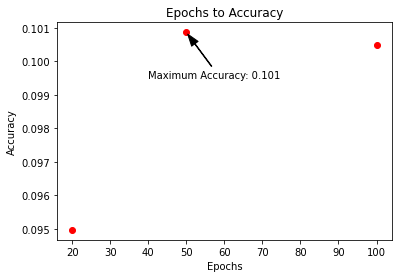

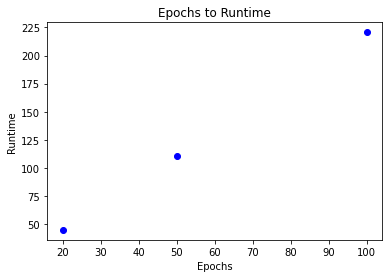

In [495]:
with open('test_results/mlp_epochs.csv') as csv_file:
    csv_reader = csv.reader(csv_file, delimiter=',')
    line_count = 0
    results = []
    for row in csv_reader:
        if line_count != 0:
            results.append({
                '1st est func' : row[0],
                '2nd est func' : row[1],
                'loss func' : row[2],
                'learning rate' : float(row[3]),
                'optimiser' : row[4],
                'momentum' : float(row[5]),
                'decay' : float(row[6]),
                'epochs' : int(row[7]),
                'hidden units' : int(row[8]),
                'accuracy' : float(row[9]),
                'runtime' : float(row[10])
            })
        line_count += 1
    
    epochs_list = []
    accuracies = []
    runtimes = []
    
    for result in results:
        epochs_list.append(result['epochs'])
        accuracies.append(result['accuracy'])
        runtimes.append(result['runtime'])
    
    plt.plot(epochs_list, accuracies, 'ro')
    
    plt.title('Epochs to Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.annotate('Maximum Accuracy: 0.101', xy=(50, 0.10087), xytext=(40, 0.0995),
                 arrowprops=dict(facecolor='black', shrink=0.05, width=0.5, headwidth=8))
    plt.show()
    
    plt.plot(epochs_list, runtimes, 'bo')
    
    plt.title('Epochs to Runtime')
    plt.xlabel('Epochs')
    plt.ylabel('Runtime')
    plt.show()

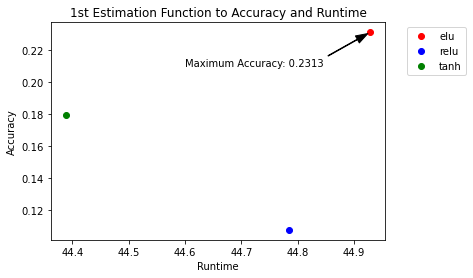

In [496]:
with open('test_results/mlp_first_activation_function.csv') as csv_file:
    csv_reader = csv.reader(csv_file, delimiter=',')
    line_count = 0
    results = []
    for row in csv_reader:
        if line_count != 0:
            results.append({
                '1st est func' : row[0],
                '2nd est func' : row[1],
                'loss func' : row[2],
                'learning rate' : float(row[3]),
                'optimiser' : row[4],
                'momentum' : float(row[5]),
                'decay' : float(row[6]),
                'epochs' : int(row[7]),
                'hidden units' : int(row[8]),
                'accuracy' : float(row[9]),
                'runtime' : float(row[10])
            })
        line_count += 1
    
    func_list = []
    accuracies = []
    runtimes = []
    
    for result in results:
        func_list.append(result['1st est func'])
        accuracies.append(result['accuracy'])
        runtimes.append(result['runtime'])
    
    plt.plot([runtimes[0]], [accuracies[0]], 'ro', label="elu")
    plt.plot([runtimes[1]], [accuracies[1]], 'bo', label="relu")
    plt.plot([runtimes[2]], [accuracies[2]], 'go', label="tanh")
    
    plt.title('1st Estimation Function to Accuracy and Runtime')
    plt.xlabel('Runtime')
    plt.ylabel('Accuracy')
    plt.annotate('Maximum Accuracy: 0.2313', xy=(runtimes[0], accuracies[0]), xytext=(44.6, 0.21),
                 arrowprops=dict(facecolor='black', shrink=0.05, width=0.5, headwidth=8))
    plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left")
    plt.show()

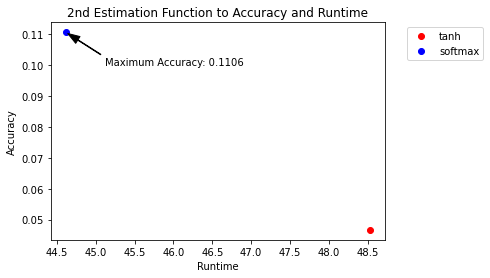

In [497]:
with open('test_results/mlp_second_activation_function.csv') as csv_file:
    csv_reader = csv.reader(csv_file, delimiter=',')
    line_count = 0
    results = []
    for row in csv_reader:
        if line_count != 0:
            results.append({
                '1st est func' : row[0],
                '2nd est func' : row[1],
                'loss func' : row[2],
                'learning rate' : float(row[3]),
                'optimiser' : row[4],
                'momentum' : float(row[5]),
                'decay' : float(row[6]),
                'epochs' : int(row[7]),
                'hidden units' : int(row[8]),
                'accuracy' : float(row[9]),
                'runtime' : float(row[10])
            })
        line_count += 1
    
    func_list = []
    accuracies = []
    runtimes = []
    
    for result in results:
        func_list.append(result['2nd est func'])
        accuracies.append(result['accuracy'])
        runtimes.append(result['runtime'])
    
    plt.plot([runtimes[0]], [accuracies[0]], 'ro', label="tanh")
    plt.plot([runtimes[1]], [accuracies[1]], 'bo', label="softmax")
    
    plt.title('2nd Estimation Function to Accuracy and Runtime')
    plt.xlabel('Runtime')
    plt.ylabel('Accuracy')
    plt.annotate('Maximum Accuracy: 0.1106', xy=(runtimes[1], 0.1106), xytext=(runtimes[1] + 0.5, 0.10),
                 arrowprops=dict(facecolor='black', shrink=0.05, width=0.5, headwidth=8))
    plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left")
    plt.show()

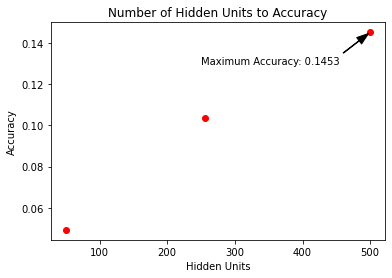

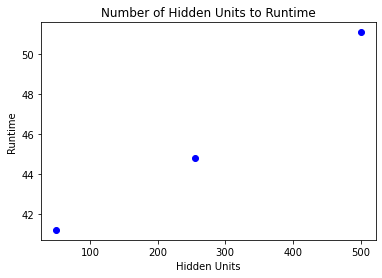

In [498]:
with open('test_results/mlp_hidden_units.csv') as csv_file:
    csv_reader = csv.reader(csv_file, delimiter=',')
    line_count = 0
    results = []
    for row in csv_reader:
        if line_count != 0:
            results.append({
                '1st est func' : row[0],
                '2nd est func' : row[1],
                'loss func' : row[2],
                'learning rate' : float(row[3]),
                'optimiser' : row[4],
                'momentum' : float(row[5]),
                'decay' : float(row[6]),
                'epochs' : int(row[7]),
                'hidden units' : int(row[8]),
                'accuracy' : float(row[9]),
                'runtime' : float(row[10])
            })
        line_count += 1
    
    hidden_list = []
    accuracies = []
    runtimes = []
    
    for result in results:
        hidden_list.append(result['hidden units'])
        accuracies.append(result['accuracy'])
        runtimes.append(result['runtime'])
    
    plt.plot(hidden_list, accuracies, 'ro')
    
    plt.title('Number of Hidden Units to Accuracy')
    plt.xlabel('Hidden Units')
    plt.ylabel('Accuracy')
    plt.annotate('Maximum Accuracy: 0.1453', xy=(hidden_list[2], accuracies[2]), xytext=(250, 0.13),
                 arrowprops=dict(facecolor='black', shrink=0.05, width=0.5, headwidth=8))
    plt.show()
    
    plt.plot(hidden_list, runtimes, 'bo')
    
    plt.title('Number of Hidden Units to Runtime')
    plt.xlabel('Hidden Units')
    plt.ylabel('Runtime')
    plt.show()

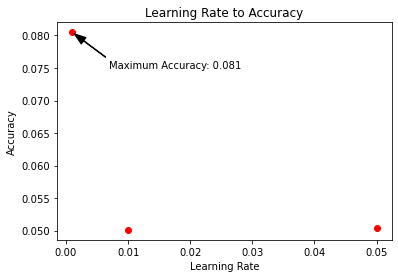

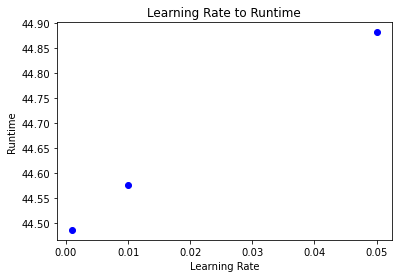

In [499]:
with open('test_results/mlp_learning_rates.csv') as csv_file:
    csv_reader = csv.reader(csv_file, delimiter=',')
    line_count = 0
    results = []
    for row in csv_reader:
        if line_count != 0:
            results.append({
                '1st est func' : row[0],
                '2nd est func' : row[1],
                'loss func' : row[2],
                'learning rate' : float(row[3]),
                'optimiser' : row[4],
                'momentum' : float(row[5]),
                'decay' : float(row[6]),
                'epochs' : int(row[7]),
                'hidden units' : int(row[8]),
                'accuracy' : float(row[9]),
                'runtime' : float(row[10])
            })
        line_count += 1
    
    learning_list = []
    accuracies = []
    runtimes = []
    
    for result in results:
        learning_list.append(result['learning rate'])
        accuracies.append(result['accuracy'])
        runtimes.append(result['runtime'])
    
    plt.plot(learning_list, accuracies, 'ro')
    
    plt.title('Learning Rate to Accuracy')
    plt.xlabel('Learning Rate')
    plt.ylabel('Accuracy')
    plt.annotate('Maximum Accuracy: 0.081', xy=(learning_list[2], accuracies[2]), xytext=(0.007, 0.075),
                 arrowprops=dict(facecolor='black', shrink=0.05, width=0.5, headwidth=8))
    plt.show()
    
    plt.plot(learning_list, runtimes, 'bo')
    
    plt.title('Learning Rate to Runtime')
    plt.xlabel('Learning Rate')
    plt.ylabel('Runtime')
    plt.show()

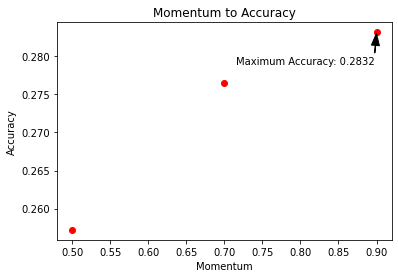

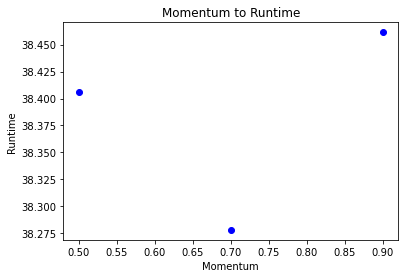

In [500]:
with open('test_results/mlp_momentums.csv') as csv_file:
    csv_reader = csv.reader(csv_file, delimiter=',')
    line_count = 0
    results = []
    for row in csv_reader:
        if line_count != 0:
            results.append({
                '1st est func' : row[0],
                '2nd est func' : row[1],
                'loss func' : row[2],
                'learning rate' : float(row[3]),
                'optimiser' : row[4],
                'momentum' : float(row[5]),
                'decay' : float(row[6]),
                'epochs' : int(row[7]),
                'hidden units' : int(row[8]),
                'accuracy' : float(row[9]),
                'runtime' : float(row[10])
            })
        line_count += 1
    
    momentum_list = []
    accuracies = []
    runtimes = []
    
    for result in results:
        momentum_list.append(result['momentum'])
        accuracies.append(result['accuracy'])
        runtimes.append(result['runtime'])
    
    plt.plot(momentum_list, accuracies, 'ro')
    
    plt.title('Momentum to Accuracy')
    plt.xlabel('Momentum')
    plt.ylabel('Accuracy')
    plt.annotate('Maximum Accuracy: 0.2832', xy=(momentum_list[2], accuracies[2]), xytext=(0.715, 0.279),
                 arrowprops=dict(facecolor='black', shrink=0.05, width=0.5, headwidth=8))
    plt.show()
    
    plt.plot(momentum_list, runtimes, 'bo')
    
    plt.title('Momentum to Runtime')
    plt.xlabel('Momentum')
    plt.ylabel('Runtime')
    plt.show()

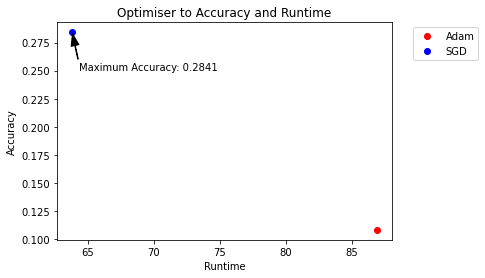

In [501]:
with open('test_results/mlp_optimisers.csv') as csv_file:
    csv_reader = csv.reader(csv_file, delimiter=',')
    line_count = 0
    results = []
    for row in csv_reader:
        if line_count != 0:
            results.append({
                '1st est func' : row[0],
                '2nd est func' : row[1],
                'loss func' : row[2],
                'learning rate' : float(row[3]),
                'optimiser' : row[4],
                'momentum' : float(row[5]),
                'decay' : float(row[6]),
                'epochs' : int(row[7]),
                'hidden units' : int(row[8]),
                'accuracy' : float(row[9]),
                'runtime' : float(row[10])
            })
        line_count += 1
    
    opt_list = []
    accuracies = []
    runtimes = []
    
    for result in results:
        opt_list.append(result['optimiser'])
        accuracies.append(result['accuracy'])
        runtimes.append(result['runtime'])
    
    plt.plot([runtimes[0]], [accuracies[0]], 'ro', label="Adam")
    plt.plot([runtimes[1]], [accuracies[1]], 'bo', label="SGD")
    
    plt.title('Optimiser to Accuracy and Runtime')
    plt.xlabel('Runtime')
    plt.ylabel('Accuracy')
    plt.annotate('Maximum Accuracy: 0.2841', xy=(runtimes[1], accuracies[1]), xytext=(runtimes[1] + 0.5, 0.25),
                 arrowprops=dict(facecolor='black', shrink=0.05, width=0.5, headwidth=8))
    plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left")
    plt.show()